Сидоренко Максим 16-в-2

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('C:\poker-hand-training-true.data.txt', sep=",", header=None, 
                   names = ["S1","C1","S2","C2","S3","C3","S4","C4","S5","C5","class"])
data.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,class
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25010 entries, 0 to 25009
Data columns (total 11 columns):
S1       25010 non-null int64
C1       25010 non-null int64
S2       25010 non-null int64
C2       25010 non-null int64
S3       25010 non-null int64
C3       25010 non-null int64
S4       25010 non-null int64
C4       25010 non-null int64
S5       25010 non-null int64
C5       25010 non-null int64
class    25010 non-null int64
dtypes: int64(11)
memory usage: 2.1 MB


Набор данных представляет собой 5 карт (колоды 52 карты) 4-х разных мастей. 
S - масть карты
С - ранг карты (где 0 - туз, 1 - "двойка" ... 13 - "король") 
№ - номер карты в руке (1 - 5)


class - получившаяся комбинация, где:
0 - ничего в руке
1 - одна пара, 2 карты равного ранга
2 - две пары, 2 пары по 2 карты равного ранга
3 - тройка (сет), три карты одного ранга
4 - стрит, 5 карт последовательных рангов разных мастей
5 - флеш, 5 карт одной масти в любом порядке рангов
6 - фул-хаус,  пара и тройка любых мастей
7 - каре, 4 одноранговые карты
8 - стрит-флеш, 5 последовательных карт одной масти
9 - роял-флеш, 5 карт одной масти от "десятки" до "Туза"

In [25]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25008 entries, 0 to 25009
Data columns (total 11 columns):
S1       25008 non-null int64
C1       25008 non-null int64
S2       25008 non-null int64
C2       25008 non-null int64
S3       25008 non-null int64
C3       25008 non-null int64
S4       25008 non-null int64
C4       25008 non-null int64
S5       25008 non-null int64
C5       25008 non-null int64
class    25008 non-null int64
dtypes: int64(11)
memory usage: 2.3 MB


Построим гистограмму, для оценки принадлежности к классу

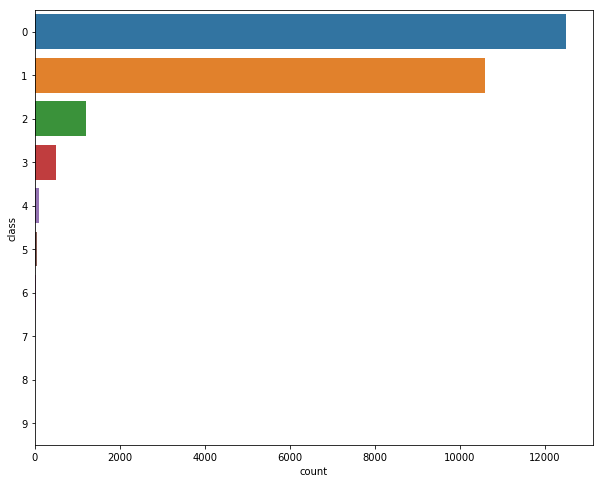

In [26]:
sns.countplot(data=data, y='class')
plt.show()

Соотношение количество элементов заметно отличается, поэтому будем считать, что классы несбалансированы.
Будем использовать ROC-кривую, поскольку она дает адекватную оценку качества работы алгоритма, где классы несбалансированы и их размеры выборки отличаются друг от друга несущественно (не на порядок)

In [27]:
numerical_columns = [i for i in data.columns if data[i].dtype.name != 'object']
categorial_columns = [i for i in data.columns if data[i].dtype.name == 'object']
print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)


numerical:  ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'class']
categorial:  []


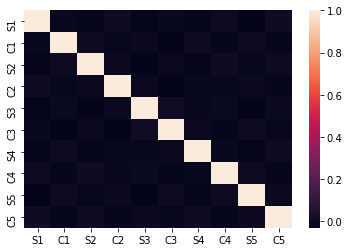

          S1        C1        S2        C2        S3        C3        S4  \
S1  1.000000 -0.010273 -0.021248  0.008290 -0.019683 -0.009980 -0.017255   
C1 -0.010273  1.000000  0.004413 -0.010951 -0.000288 -0.026273  0.004109   
S2 -0.021248  0.004413  1.000000 -0.002424 -0.029276 -0.005299 -0.020945   
C2  0.008290 -0.010951 -0.002424  1.000000 -0.005347 -0.024678 -0.008471   
S3 -0.019683 -0.000288 -0.029276 -0.005347  1.000000  0.017920 -0.013000   
C3 -0.009980 -0.026273 -0.005299 -0.024678  0.017920  1.000000 -0.003168   
S4 -0.017255  0.004109 -0.020945 -0.008471 -0.013000 -0.003168  1.000000   
C4  0.003847 -0.014369  0.012050 -0.013004  0.001849 -0.016310 -0.008766   
S5 -0.024137  0.004854 -0.011842  0.000607 -0.030291  0.003745 -0.018232   
C5  0.006715 -0.016983  0.005777 -0.016469 -0.001971 -0.010905  0.005265   

          C4        S5        C5  
S1  0.003847 -0.024137  0.006715  
C1 -0.014369  0.004854 -0.016983  
S2  0.012050 -0.011842  0.005777  
C2 -0.013004  0.000607 

In [28]:
data_corr = data.drop(['class'], axis=1).corr()
sns.heatmap(data_corr)
plt.show()
print(data_corr)

In [33]:
# разделим полученные данные на данные для обучения и теста
X = np.array(data)
y = np.array(data['S1']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(16755, 11)
(8253, 11)


In [34]:
X = np.array(data)
y = np.array(data['class']) 

In [35]:
# найдем оптимальный радиус для классификатора ближайших соседей

rnc = RadiusNeighborsClassifier(outlier_label=1)

params = {'radius': np.arange(4, 5, 0.1)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, ' at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=7, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.5856759176365264  at radius: 4.9
test score:  0.618684114867


In [36]:
#найдем оптимальные глубину и количества учитываемых параметров для классификатора решающее дерево
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,10)), 'max_features': list(range(1,10))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 1.0 	 at features number: 8 	 at depth: 3
test score:  1.0


In [37]:
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

In [38]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        # Алгоритм. 
# Мы пройдем от нулевого радиусf до двойного радиуса классификатора 
# с простейшим шагом (др). Если экземпляр: 
# Ноль радуйс + др - соответствует 100% 
# Классификатор raduis + dr - соответствует 50% 
# Двойной классификатор raduis + dr и далее - соответствует 0% 
# Еси результат - промежуточное значение то каждый шаг соответствует своему собственному процентному значению. 
# Если прогнозируемый экземпляр меняет свой класс, этот экземпляр принадлежит текущему радиусу, это и будет соответствующий процент.
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),7), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1, 2, 3, 4, 5, 6]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

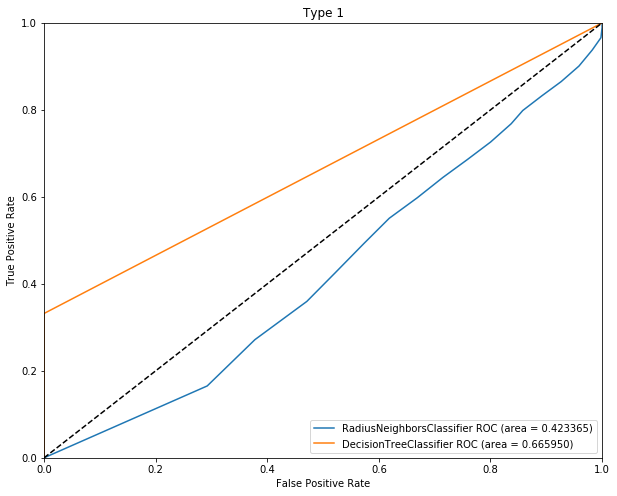

In [39]:
# ROC
plt.figure(figsize=(10,8))
mrnc = MyRadiusNeighborsClassifier(outlier_label=7, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,1], probas_mrnc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,1], probas_dtc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('Type 1')
plt.show()

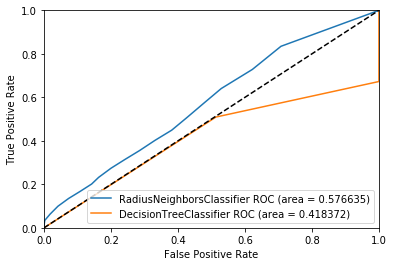

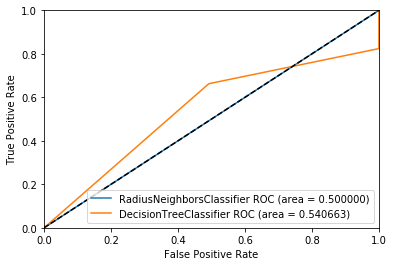

In [44]:
mrnc = MyRadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,1], -probas_mrnc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=4, max_features=2)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,1], -probas_dtc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.show()

mrnc = MyRadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
probas_mrnc2 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,2], -probas_mrnc0[:,2])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=4, max_features=2)
probas_dtc2 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,2], -probas_dtc0[:,2])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.show()

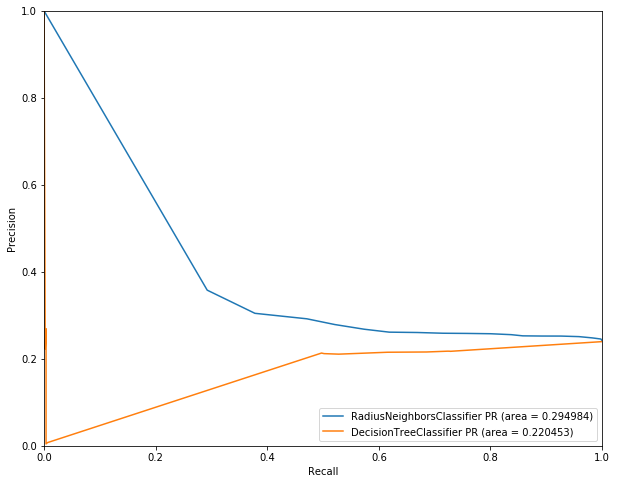

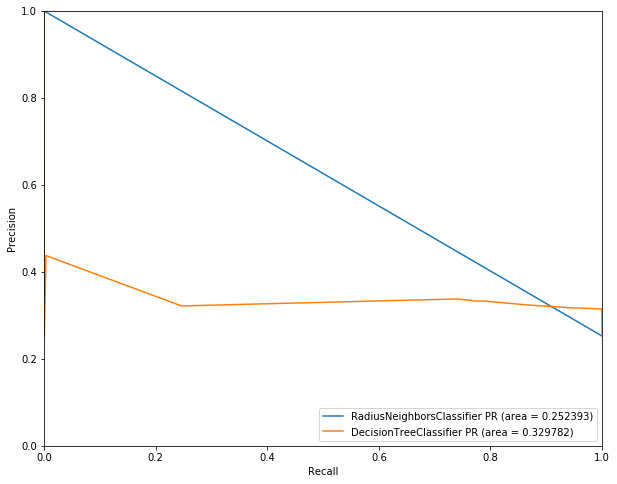

In [43]:
plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test[:,1],probas_mrnc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test[:,1],probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.show()

plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test[:,2], probas_mrnc1[:,2])
aps_mrnc1 = average_precision_score(y_test[:,2],probas_mrnc1[:,2])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test[:,2], probas_dtc1[:,2])
aps_dtc1 = average_precision_score(y_test[:,2],probas_dtc1[:,2])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.show()